In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import os, random
import sys
sys.path.append('../')
import astropy

from data import KMTData
from data import OGLEData

random.seed(42)

In [ ]:
event = OGLEData('/home/fran/data/OGLE_ews/2017/blg-0525')
fig, ax = plt.subplots(figsize=(25, 10))
event.remove_worst_outliers(window_size=11, mad_cutoff=7)
event.plot(ax)

# Query JPL horizons and get Eath's orbital elements for each $t_i$


In [ ]:
from astroquery.jplhorizons import Horizons
from astropy.time import Time
from astropy import units as u

start = Time(event.tables[0]['HJD'][0], format='jd')
stop = Time(event.tables[0]['HJD'][-1], format='jd')

epochs={'start':start.iso[:10], 'stop':stop.iso[:10], 'step':'6h'}
obj = Horizons(id='399', id_type='id', epochs=epochs)

In [ ]:
elements = obj.elements()
elements

In [ ]:
def equatorial_to_ecliptic_coordinates(coordinates, obs_time):
    # Earth's obliquity angle
    T = (obs_time - 2451545)/365.25/100 # julian centuries since J2000
    eps = 23.439279 - (46.815/60**2)*T
    R = np.array([[1, 0, 0],
                   [0, np.cos(eps), np.sin(eps)],
                   [0, -np.sin(eps), np.cos(eps)]])
    
    ra = coordinates.ra.to(u.rad).value
    dec = coordinates.dec.to(u.rad).value
    coord_ec_cartesian = np.array([np.cos(ra)*np.cos(dec),
                                   np.sin(ra)*np.cos(dec),
                                   np.sin(dec)])
    
    # Transformation between equatorial and ecliptical coordinates
    coord_eq_cartesian = R @ coord_ec_cartesian[:, np.newaxis]
    
    b = np.arcsin(coord_eq_cartesian[2])
    l = 2*np.arctan(coord_eq_cartesian[1]/(np.cos(b) + coord_eq_cartesian[0]))
    
    return {'l':l, 'b':b}


# Calculate $\gamma_n(t)$ and $\gamma_w(t)$

In [ ]:
event_ecl_coord = equatorial_to_ecliptic_coordinates(event.coordinates, 0.5*(event.tables[0]['HJD'][0] + event.tables[0]['HJD'][-1]))
lambda_0  = event_ecl_coord['l']
beta_0  = event_ecl_coord['b']

t = np.array(elements['datetime_jd']) # JD
e = np.array(elements['e'])*0
tp = np.array(elements['Tp_jd']) # JD
n = (2*np.pi/365.25) # mean motion
Phi_gamma = (77.86)*np.pi/180 # true anomaly at vernal eq. on J2000
r_sun = 1 - e*np.cos(n*(t - tp)) # to 1st order in e
lambda_sun = n*(t - tp) - Phi_gamma + 2*e*np.sin(n*(t - tp)) # to 1st order in e

gamma_w = r_sun*np.sin((lambda_sun - lambda_0))
gamma_n = r_sun*np.sin(beta_0)*np.cos(lambda_sun - lambda_0)

gamma_w_dot = n*((1 + e*np.cos(n*(t - tp)))*np.cos(lambda_sun - lambda_0)+\
    e*np.sin(n*(t - tp))*np.sin(lambda_sun - lambda_0))
gamma_n_dot = -n*np.sin(beta_0)*((1 + e*np.cos(n*(t - tp)))*np.sin(lambda_sun - lambda_0) -\
    e*np.sin(n*(t - tp))*np.cos(lambda_sun - lambda_0))

gamma_w_ddot = -n**2*(1 + 2*e*np.cos(n*(t - tp)))*np.sin(lambda_sun - lambda_0)
gamma_n_ddot = -n**2*np.sin(beta_0)*(1 + 2*e*np.cos(n*(t - tp)))*np.cos(lambda_sun - lambda_0)

In [ ]:
fig, ax = plt.subplots(3,1, figsize=(25, 10), sharex=True)
fig.subplots_adjust(hspace=0.02)
ax[0].plot(t, gamma_w, 'C0', label='gamma_w')
ax[0].plot(t, gamma_n, 'C1', label='gamma_n')
ax[1].plot(t, gamma_w_dot, 'C0', label='gamma_w_dot')
ax[1].plot(t, gamma_n_dot, 'C1', label='gamma_n_dot')
ax[2].plot(t, gamma_w_ddot, 'C0', label='gamma_w_ddot')
ax[2].plot(t, gamma_n_ddot, 'C1', label='gamma_n_ddot')
ax[2].set_xlabel('JD')
for a in ax.ravel():
    a.grid()

In [ ]:
np.interp(event.tables[0]['HJD'], t, gamma_w)

In [ ]:
plt.plot(event.tables[0]['HJD'], np.interp(event.tables[0]['HJD'], t, gamma_w_ddot))

# Interpolation in PyMC3

In [ ]:
import exoplanet as xo

x = t
points = [x]
values = gamma_w

print(len(points[0]))
print(len(values))
print(type(points[0]))
print(type(values))
print(np.shape(points))
print(np.shape(values))
print(points)
print(values)

# x = np.sort(np.random.uniform(-5, 5, 25))
# points = [x]
# values = x**3-x**2
interpolator = xo.interp.RegularGridInterpolator(points, values[:, None])
x_ = np.linspace(2457400, 2457600, 1000)
print(interpolator.evaluate(x_[:, None]).eval()[:10])

# plt.plot(x_, interpolator.evaluate(x_[:, None]).eval(), label="interpolation")
# plt.plot(x, values, "o", label="control points")
# plt.xlabel("x")
# plt.ylabel("y")
# plt.legend(fontsize=12);

In [ ]:
with pm.Model() as model:

    # The value passed into the interpolator must have the shape
    # (ntest, ndim), but in our case that is (1, 1)
    xval = pm.Uniform("x", lower=-8, upper=8, shape=(1, 1))

    # Evaluate the interpolated model and extract the scalar value
    # we want
    mod = pm.Deterministic("y", interpolator.evaluate(xval)[0, 0])

    # The usual likelihood
    pm.Normal("obs", mu=mod, sd=data_sd, observed=data_mu)

    # Sampling!
    trace = pm.sample(draws=1000, tune=2000, step_kwargs=dict(target_accept=0.9))

# Alternative parametrization for parallax

In [2]:
from sympy import *
init_printing(use_unicode=False, wrap_line=True)

In [37]:
t0p, t0, u0, omegaE, piE, theta, gamma_w, gamma_n,\
    gamma_w_dot, gamma_n_dot, gamma_w_ddot, gamma_n_ddot =\
    symbols(r"t'_0 t_0 u_0 \omega_E, \pi_E \theta \gamma_w \gamma_n \dot{\gamma}_w \dot{\gamma}_n \ddot{\gamma}_w \ddot{\gamma}_n",
    real=True)

u0p, v0p, ap, av = symbols(r"u'_o v'_0 a_\parallel a_\bot", real=True)

In [38]:
up = -(t0p - t0)*omegaE + piE*(cos(theta)*gamma_w-sin(theta)*gamma_n)
uv = u0 + piE*(sin(theta)*gamma_w-cos(theta)*gamma_n)
up_dot = -omegaE + piE*(cos(theta)*gamma_w_dot - sin(theta)*gamma_n_dot)
uv_dot =  piE*(sin(theta)*gamma_w_dot + cos(theta)*gamma_n_dot)
up_ddot =  piE*(cos(theta)*gamma_w_ddot - sin(theta)*gamma_n_ddot)
uv_ddot =  piE*(sin(theta)*gamma_w_ddot + cos(theta)*gamma_n_ddot)

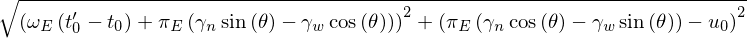

In [46]:
u = simplify(sqrt(up**2 + uv**2))
u

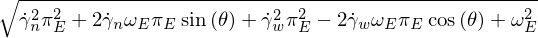

In [40]:
u_dot = simplify(sqrt(up_dot**2 + uv_dot**2))
u_dot

In [41]:
u_ddot = simplify(sqrt(up_ddot**2 + uv_ddot**2))
u_ddot